In [35]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

SEED = 777
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


In [36]:
from datetime import datetime
now = datetime.now()

# Training Hyperparameters
EPOCHS = 10
BATCH_SIZE = 64
LR = 0.001

ROOT_DIR = os.getcwd()
LOG_DIR = os.path.join(ROOT_DIR, "logs", now.strftime("%Y%m%d-%H%M%S"))
LOG_ITER = 100
CKPT_DIR = os.path.join(ROOT_DIR, "checkpoints")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(CKPT_DIR):
    os.makedirs(CKPT_DIR)


In [37]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# CIFAR-10 Dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)


Files already downloaded and verified


In [38]:
# CIFAR-10 Test Dataset
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# CIFAR-10 Test Dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

Files already downloaded and verified


In [39]:
# CNN Model for CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [40]:
# Initialize Model
model = CNN().to(DEVICE)


In [41]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Setup Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(LOG_DIR)


In [42]:
%pip install tqdm
from tqdm import tqdm

# Train the Model
iteration = 0
for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc="Epoch {}".format(epoch))
    for images, labels in pbar:
        iteration += 1
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Tensorboard
        writer.add_scalar("Loss", loss, epoch * len(train_loader) + iteration)
        
        # Save the Model
        if iteration % 100 == 0:
            torch.save(model.state_dict(), os.path.join(CKPT_DIR, "latest.ckpt".format(iteration)))
            pbar.set_postfix(loss=loss.item())

    print(
        "Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}"
        .format(epoch + 1, EPOCHS, iteration + 1, len(train_loader), loss.item())
    )


Note: you may need to restart the kernel to use updated packages.


Epoch 0: 100%|██████████| 782/782 [00:25<00:00, 31.27it/s, loss=1.58]


Epoch: [1/10], Step: [783/782], Loss: 1.2788


Epoch 1: 100%|██████████| 782/782 [00:24<00:00, 31.80it/s, loss=1.46]


Epoch: [2/10], Step: [1565/782], Loss: 1.4667


Epoch 2: 100%|██████████| 782/782 [00:24<00:00, 32.04it/s, loss=1.43]


Epoch: [3/10], Step: [2347/782], Loss: 1.1637


Epoch 3: 100%|██████████| 782/782 [00:23<00:00, 32.74it/s, loss=1.47]


Epoch: [4/10], Step: [3129/782], Loss: 0.8245


Epoch 4: 100%|██████████| 782/782 [00:24<00:00, 32.27it/s, loss=1.61] 


Epoch: [5/10], Step: [3911/782], Loss: 1.2044


Epoch 5: 100%|██████████| 782/782 [00:24<00:00, 32.07it/s, loss=1.34]


Epoch: [6/10], Step: [4693/782], Loss: 1.1353


Epoch 6: 100%|██████████| 782/782 [00:24<00:00, 32.39it/s, loss=1.05]


Epoch: [7/10], Step: [5475/782], Loss: 0.8025


Epoch 7: 100%|██████████| 782/782 [00:24<00:00, 32.08it/s, loss=1.04] 


Epoch: [8/10], Step: [6257/782], Loss: 0.6851


Epoch 8: 100%|██████████| 782/782 [00:25<00:00, 31.07it/s, loss=1.19] 


Epoch: [9/10], Step: [7039/782], Loss: 1.1096


Epoch 9: 100%|██████████| 782/782 [00:24<00:00, 31.58it/s, loss=1.1]  

Epoch: [10/10], Step: [7821/782], Loss: 0.8901


In [43]:
# Test the Model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(
        "Accuracy of the model on the test images: {} %".format(
            100 * correct / total
        )
    )



100%|██████████| 157/157 [00:11<00:00, 13.51it/s] 

Accuracy of the model on the test images: 59.19 %


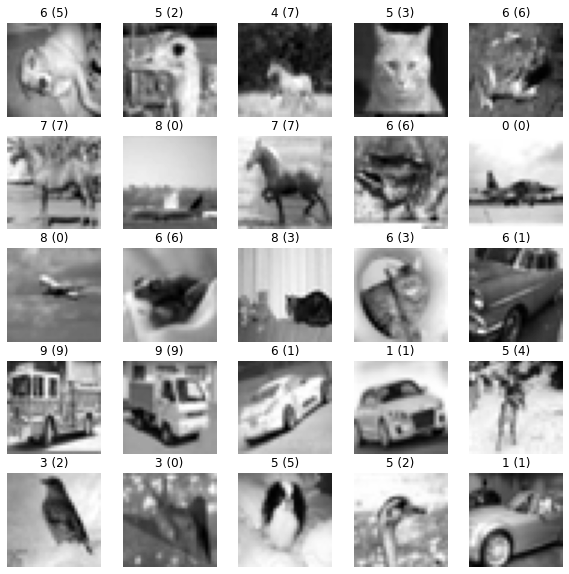

In [44]:
# Show some images
images, labels = next(iter(train_loader))
images = images.to(DEVICE)
labels = labels.to(DEVICE)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(images[i][0].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title("{} ({})".format(predicted[i].item(), labels[i].item()))
    ax.axis("off")